# Mudcard
- **I know the pipeline but have a hard time keeping track of the code/syntax especially the hyperparameter tuning - do I need to have everything memorized for the exam?**
    - Yes, these steps are crucial.
    - You don't need to memorize code but you need to know the pseudo-code and the correct order the steps need to be performed
- **how are we sure that there isn't some alpha out of the logspace range such that it yields the best model accuracy?**
    - if you plot the training and validation curves for alpha, and you see both regimes of overfitting and underfitting, there is no better alpha outside of the range
    - if you only see either overfitting or underfitting, you need to increase the range of alpha
- **what is the difference between using a ridge regression object versus an 'l2' parameter in the penalty for a linear regression, or are both required?**
    - if you use sklearn's Ridge, that's linear regression with l2 regularization, there is no penalty argument for Ridge.
    - sklearn's LogisticRegression has a penalty argument which can be l1, l2, elastic net, etc. that's where the penalty of l2 needs to be set if you want to do Ridge regularization in logistic regression.
    - sklearn's LinearRegression has no penalty argument either, that's just vanilla linear regression with no regularization
- **purpose of hyper parameter tuning**
    - find the best model
- **For quiz2, if we use a Ridge Regression instead, do we need to check the MSE instead of the Accuracy_score? Since if it's a regression, not a classification, an accuracy_score here has no meaning.**
    - In the basic split CV, no because when you switch to Ridge, the default loss is changed to MSE
    - When you use GridSearchCV, yes, you need to change accuracy to MSE.
        - Note that Quiz 2 was not on the GirdSearchCV code :)

# <center> Lecture 10: Split timeseries data</center>

By the end of this lecture, you will be able to
- perform autocorrelation 
- apply autoregression (AR)
- describe various other linear time series models



# The supervised ML pipeline

**0. Data collection/manipulation**: you might have multiple data sources and/or you might have more data than you need
   - you need to be able to read in datasets from various sources (like csv, excel, SQL, parquet, etc)
   - you need to be able to filter the columns/rows you need for your ML model
   - you need to be able to combine the datasets into one dataframe 

**1. Exploratory Data Analysis (EDA)**: you need to understand your data and verify that it doesn't contain errors
   - do as much EDA as you can!
    
<span style="background-color: #FFFF00">**2. Split the data into different sets**: most often the sets are train, validation, and test (or holdout)</span>
   - practitioners often make errors in this step!
   - you can split the data randomly, based on groups, based on time, or any other non-standard way if necessary to answer your ML question

**3. Preprocess the data**: ML models only work if X and Y are numbers! Some ML models additionally require each feature to have 0 mean and 1 standard deviation (standardized features)
   - often the original features you get contain strings (for example a gender feature would contain 'male', 'female', 'non-binary', 'unknown') which needs to be transformed into numbers
   - often the features are not standardized (e.g., age is between 0 and 100) but it needs to be standardized
    
**4. Choose an evaluation metric**: depends on the priorities of the stakeholders
   - often requires quite a bit of thinking and ethical considerations
     
**5. Choose one or more ML techniques**: it is highly recommended that you try multiple models
   - start with simple models like linear or logistic regression
   - try also more complex models like nearest neighbors, support vector machines, random forest, etc.
    
**6. Tune the hyperparameters of your ML models (aka cross-validation or hyperparameter tuning)**
   - ML techniques have hyperparameters that you need to optimize to achieve best performance
   - for each ML model, decide which parameters to tune and what values to try
   - loop through each parameter combination
       - train one model for each parameter combination
       - evaluate how well the model performs on the validation set
   - take the parameter combo that gives the best validation score
   - evaluate that model on the test set to report how well the model is expected to perform on previously unseen data
    
**7. Interpret your model**: black boxes are often not useful
   - check if your model uses features that make sense (excellent tool for debugging)
   - often model predictions are not enough, you need to be able to explain how the model arrived to a particular prediction (e.g., in health care)

## Recall from Lecture 05

- **the i.i.d. assumption**: the examples in the training set are independently and identically distributed according to $D$
    - every $x_i$ is freshly sampled from $D$ and then labelled by $f$
    - that is, $x_i$ and $y_i$ are picked independently of the other instances
    - $S$ is a window through which the learner gets partial info about $D$ and the labeling function $f$
    - the larger the sample gets, the more likely it is that $D$ and $f$ are accurately reflected
- examples of not iid data:
   - data generated by time-dependent processes
   - data has group structure (samples collected from e.g., different subjects, experiments, measurement devices)
- we will get back to this later in the term 
- if there is any sort of time or group structure in your data, it is likely non-iid
    - **time series data**
        - **values are not independent**
        - stocks price
        - covid19 cases
        - weather data
    - **group structure:**
        - **samples are not identically distributed, $D$ might be different for each group**
        - a person appears multiple times in the dataset (e.g., hospital/doctor visits)
        - data is collected on multiple instrucments (e.g., equipment failure prediction)
        - geographical data (e.g., data collected about various cities, counties, states, countries)

        

## Ask yourself these questions!
- What is the intended use of the model? What is it supposed to do/predict?
- What data do you have available at the time of prediction?
- Your split must mimic the intended use of the model only then will you accurately estimate how well the model will perform on previously unseen points (generalization error).
- two examples:
    - if your dataset contains time series features, make sure you don't use future info to predict the past, that's information leakage
    - if you want to predict the outcome of a new patient's visit to the ER:
        - your test score must be based on patients not included in training and validation
        - your validation score must be based on patients not included in training
        - points of one patient should not be distributed over multiple sets because your generalization error will be off

We cover time series data today and group structure during the next lecture


<font color='lightgray'>By the end of this lecture, you will be able to</font>
- **perform autocorrelation**
- <font color='lightgray'>apply autoregression (AR)</font>
- <font color='lightgray'>describe various linear time series models</font>


## Time series data
- stock price, crypto price, covid-19 positive case counts, etc
- **y(t)** is our time series data
- here is an example data structure:

| time | observation | 
| - | :-: |
| $t_0$ | $y(t_0)$ |
| $t_1$ | $y(t_1)$ |
| $t_2$ | $y(t_2)$ |
| ... | ... |
| $t_i$ | $y(t_i)$ |
| ... | ... |
| $t_{n-1}$ | $y(t_{n-1})$ |
| $t_n$ | $y(t_n)$ |

- assumption:
    - the difference between two time points (dt) is constant 
        - e.g., 1 minute, 5 minutes, 1 hour, or 1 day
    - the observation is continuous so there are no missing values 

## Autocorrelation
- the correlation of the time series data with a delayed copy of itself
- delay is shown on the x axis, correlation coefficient on the y axis
- if delay = 0, the correlation coefficient is 1
- if the delay is short, autocorrelation can be high
- autocorrelation tends to subside for longer delays
- let's check an example

(3650, 2)
         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


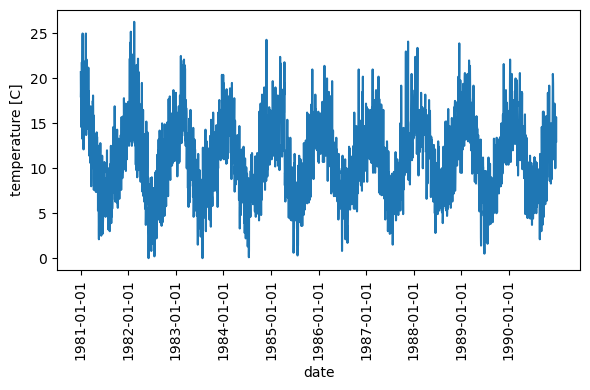

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

df = pd.read_csv('../data/daily-min-temperatures.csv')
print(df.shape)
print(df.head())

plt.figure(figsize=(6,4))

plt.plot(df['Temp'])
plt.xticks(np.arange(len(df['Date']))[::365],df['Date'].iloc[::365],rotation=90)
plt.xlabel('date')
plt.ylabel('temperature [C]')
plt.tight_layout()
plt.show()


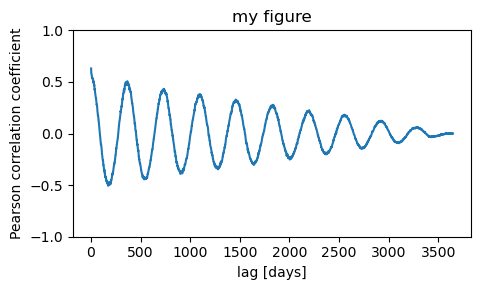

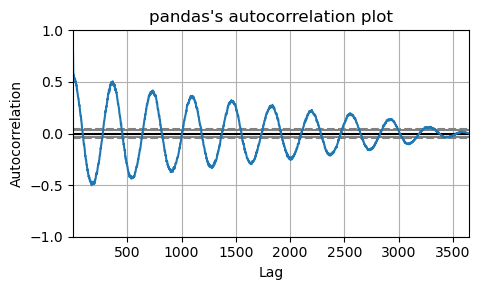

In [4]:
# let's create an autocorrelation plot

lags = np.arange(3650)
corr_coefs = np.zeros(3650)

for i in np.arange(len(lags)-2):
    x = df['Temp'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = df['Temp'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by ... (to be answered in Quiz 1)
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/df['Temp'].shape[0]

plt.figure(figsize=(5,3))
plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('my figure')
plt.tight_layout()
plt.show()

# a one-liner
plt.figure(figsize=(5,3))
pd.plotting.autocorrelation_plot(df['Temp'])
plt.title("pandas's autocorrelation plot")
plt.tight_layout()
plt.show()

## Quiz 1

What is `x.shape[0]/df['Temp'].shape[0]` in the last line of the for loop and why is it needed?


<font color='lightgray'>By the end of this lecture, you will be able to</font>
- <font color='lightgray'>perform autocorrelation</font>
- **apply autoregression (AR)**
- <font color='lightgray'>describe various linear time series models</font>


# AR(p) - Autoregression with an order of p

- recall what the linear regression model is from Lecture 07:
    ### <center>$f(X_i) = y_i' = w_0 + w_1 X_{i1} + w_2 X_{i2} +$ ... $= w_0 + \sum_{j=1}^{d} w_j  X_{ij} $</center>
  
- the goal of autoregression is to predict a future value of y based on the histrocial values of y
- the equation for linear regression becomes
    ### <center>$y(t_i)' = w_0 + w_1 y(t_{i-1}) + w_2 y(t_{i-2}) + w_3 y(t_{i-3}) $ ... $= w_0 + \sum_{j=1}^{p} w_j  y(t_{i-j}) $</center>
- sometimes we want to predict y at time $t_{i+1}$ or an arbitrary $t_{i+n}$.
    - i.e., you have hourly temperature observations, you are camping and retire to your tent around 10pm. You want to know if it will be freezing 8 hours from now when you wake up. n = 8 in this case.

## Let's prepare the target variable and the feature matrix using $y(t)$ 

- the target variable and lag features:

|feature p 	| ... | feature 2 | feature 1 | <font color='red'>target variable</font>|
| :-: | :-: | :-: |:-: |:-: |
|    $y(t_{i-j-p})$   	| ... | $y(t_{i-2-j})$   	| $y(t_{i-1-j})$	    | <font color='red'>$y(t_{i-j})$</font>	|
|    ...      	| ... | ...     	| ...	    | <font color='red'>...</font>	|
|    $y(t_{i-1-p})$   	| ... | $y(t_{i-3})$   	| $y(t_{i-2})$	    | <font color='red'>$y(t_{i-1})$</font>	|
|    $y(t_{i-p})$   	| ... | $y(t_{i-2})$   	| $y(t_{i-1})$	    | <font color='red'>$y(t_{i})$</font>	|

- the features are shifted with respect to the original observation with a dt lag
- this feature matrix should still be split based on time (e.g., older observations in train, most recent observations in test)

In [6]:
y = df['Temp']
X = pd.concat([df['Temp'].shift(3),df['Temp'].shift(2),df['Temp'].shift(1)],axis=1)
X.columns = ['lag 3 days','lag 2 days','lag 1 day']
print(X.tail(10))
print(y.tail(10))

      lag 3 days  lag 2 days  lag 1 day
3640        14.7        15.4       13.1
3641        15.4        13.1       13.2
3642        13.1        13.2       13.9
3643        13.2        13.9       10.0
3644        13.9        10.0       12.9
3645        10.0        12.9       14.6
3646        12.9        14.6       14.0
3647        14.6        14.0       13.6
3648        14.0        13.6       13.5
3649        13.6        13.5       15.7
3640    13.2
3641    13.9
3642    10.0
3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, dtype: float64


## Quiz 2

We have n observations of $y(t)$. What are the limits on $j$ and $p$?

## How to split the feature matrix and target variable into train/val/test or folds?
- Any strategy using random shuffling won't work!
- This is one scenario where you want to order the points based on time and preserve that order!
    - Remember one of the goals of the ML pipeline: we want to know how well our model will perform on previously unseen data
    - In time series predictions, previously unseen data means future data
    - Your test set needs to be a simulated future data
    - The training set needs to be past/historical data
- You want the most recent observations at the end of your table and the old observations at the beginning of the table
- train_test_split:
    - set shuffle to **False**
    - split X, y to train and other
    - split other to val and test
    - You must follow these steps to make sure the oldest observations are in train and the recent observations are in test
- k-fold
    - DO NOT USE!
    - shuffle is set to **False** by default which would be good
    - but each fold is used as the validation set which breaks the time series nature of the data
- sklearn's TimeSeriesSplit
    - use x% of the most recent points as your test set
    - use TimeSeriesSplit on the rest
    - the size of the training set is different for each split but the time series nature is preserved

<center><img src="../figures/timeseriessplit.png" width="600"></center>


## Things to consider
- lag between the target variable and feature 1 can be more than 1
- due to autocorrelation, the features closer in time to the target variable tend to be more predictive
- how many features should you use?
    - treat the number of features as a hyperparameter
- how far back in time should you go when creating the feature matrix?
    - It's usually fine to go as far back as you can given the length of your time series and the number of lagged features you use
    - the more data the better


<font color='lightgray'>By the end of this lecture, you will be able to</font>
- <font color='lightgray'>perform autocorrelation</font>
- <font color='lightgray'>apply autoregression (AR)</font>
- **describe various linear time series models**


# VAR(p) - Vector Autoregression
- autoregression on multivariate time series data
- you might have multiple time series to work with (prices of multiple stocks, covid cases in multiple countries, etc)
- all of those need to be shifted by the same lag relative to the target variable
- if you have two time series data $y(t)$ and $z(t)$ for example, the regression model becomes
  ### <center>$y(t_i)' = w_0 + \sum_{j=1}^{p} w_j  y(t_{i-j}) + \sum_{k=1}^{p} w_k  z(t_{i-k})$</center>
- you need to add as many terms and the number of time series data available
- the number of coefficients to fit goes up, it is $p$ times the number of time series data

## MA(q) - Moving average with the order of q
- uses a linear combination of past error terms (aka shocks) to predict future values
    ### <center>$y(t_i)' = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... = \mu + \epsilon_t + \sum_{k=1}^{q} \theta_k \epsilon_{t-k} $</center>
- $\mu$ is the overall mean of the time series data $y(t)$
- $\epsilon_i$ are the error terms at time $i$ - normal distributions with a mean of 0 and some variance $\sigma^2_i$
- $\theta_i$ are the coefficients of the model
- $\mu$, $\epsilon_i$'s, and $\theta_i$'s are fitted to the observed data
- moving average models assume that the time series is stationary, mean ($\mu$) and variance of the time series don't change over time
- VMA - MA on multivariate time series data

## ARMA(p,q) - Autoregression with moving averages
- a combination of AR(p) and MA(q)

### <center>$y(t_i)' = c + \sum_{j=1}^{p} w_j  y(t_{i-j}) + \sum_{k=1}^{q} \theta_k \epsilon_{t-k}$</center>

- $c$ is the constants of both models so $c= w_0 + \mu$
- VARMA - ARMA on multivariate time series data

## ARIMA(p,d,q) - Autoregression with integrated moving averages
- the difference of the time series is calculated $d$ times - this is the 'integrated' part of ARIMA
    - if we have $y(t)$, the first difference is $z(t)$ where $z(t_i) = y(t_i) - y(t_{i-1})$.
    - the second difference of $y(t)$ is the first difference of $z(t)$, etc.
- then an ARMA(p,q) is fitted on the differenced series
- this formalism can handle non-stationary time series!
    - the differentiation removes the trends
- VARIMA - ARIMA on multivariate time series data

## Seasonal effects
- you can add seasonal variations to the above mentioned linear time series models
- beyond the scope of this course

## Outlook: special scenarios
- what if dt is not consant and/or each time series have its own non-uniform time?
    - for example you try to predict crypto prices based on stock prices
        - stock prices are available once per hour
        - crypto prices are only available when a trade happens (i.e., some tokens are traded rarely) or every minute
    - interpolate to a uniform time grid
        - try linear and non-linear interpolation techniques to figure out what works best
        - check out [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) for more info
        - cubic spline interpolation usually works well
- you might have a mix of time series and non-time series features
    - cvs customer purchase history
        - you know what a customer bought and when - time series part
        - you have info on the customer (gender, race, address, etc) - non-time series part


## Mud card